# Deep Learning/ RNN+Transformer/ in keras

## Training language model for generating sequences (One-to-Many)


## Import packages

In [1]:
#! pip install pretty_midi

import os
import pretty_midi
from scipy.io import wavfile
import IPython

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

#! pip install keras_nlp
from keras_nlp.layers import TransformerDecoder

import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import glob

from tensorflow.python.keras.utils.np_utils import to_categorical

student = True

2024-10-23 22:30:10.300243: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 22:30:10.305919: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 22:30:10.360896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 22:30:10.419329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 22:30:10.470453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Get the data

In [2]:
# n_x --- the number of notes (here we consider the problem as a multi-class with n_x classes)
n_x = 79
# max_midi_T_x --- the maximum number of notes we read in each midi_file
max_midi_T_x = 1000
# model_T_x --- the length of the sequences considered for the RNN model
#model_T_x = 200
model_T_x = 100
# model_n_a --- the number of neurons of each layer of the network
#model_n_a = 256
model_n_a = 32

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [3]:
DIR = './'
import urllib.request
midi_file_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midi_file in midi_file_l:
  #if os.path.isfile(DIR + midi_file) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midi_file, DIR + midi_file)

midi_file_l = glob.glob(DIR + 'cs*.mid')
print(midi_file_l)

['./cs2-3cou.mid', './cs3-2all.mid', './cs2-6gig.mid', './cs2-2all.mid', './cs1-3cou.mid', './cs5-2all.mid', './cs6-3cou.mid', './cs5-5gav.mid', './cs4-3cou.mid', './cs5-6gig.mid', './cs3-3cou.mid', './cs6-2all.mid', './cs1-4sar.mid', './cs1-5men.mid', './cs4-6gig.mid', './cs4-2all.mid', './cs3-6gig.mid', './cs3-5bou.mid', './cs6-1pre.mid', './cs2-4sar.mid', './cs3-4sar.mid', './cs3-1pre.mid', './cs2-5men.mid', './cs4-1pre.mid', './cs6-6gig.mid', './cs5-3cou.mid', './cs1-2all.mid', './cs1-6gig.mid', './cs4-4sar.mid', './cs6-5gav.mid', './cs6-4sar.mid', './cs1-1pre.mid', './cs4-5bou.mid', './cs5-1pre.mid', './cs2-1pre.mid', './cs5-4sar.mid']


## Read and convert all MIDI files

We illustrate here the content of a MIDI file. Each file contains a list of notes to be played over time. Each note is characterized by
- its `pitch` (in MIDI note number, la3=A4=69)
- its `start` time (when to start playing the note)
- its `stop` time (when to stop playing the note)
- its `duration` (which is computed as stop-start)

In [4]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_file_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes[:20]:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 62, start: 0.666526, end: 0.824421, duration: 0.157895
pitch: 62, start: 0.824421, end: 0.982316, duration: 0.157895
pitch: 57, start: 0.982316, end: 1.140211, duration: 0.157895
pitch: 53, start: 1.140211, end: 1.298105, duration: 0.157895
pitch: 57, start: 1.298105, end: 1.456000, duration: 0.157895
pitch: 50, start: 1.456000, end: 1.613895, duration: 0.157895
pitch: 53, start: 1.613895, end: 1.771790, duration: 0.157895
pitch: 55, start: 1.771790, end: 1.929684, duration: 0.157895
pitch: 57, start: 1.929684, end: 2.087579, duration: 0.157895
pitch: 58, start: 2.087579, end: 2.245474, duration: 0.157895
pitch: 57, start: 2.245474, end: 2.403369, duration: 0.157895
pitch: 58, start: 2.403369, end: 2.561263, duration: 0.157895
pitch: 55, start: 2.561263, end: 2.719158, duration: 0.157895
pitch: 57, start: 2.719158, end: 3.350737, duration: 0.631579
pitch: 60, start: 10.298106, end: 11.061264, duration: 0.763158
pitch: 58, start: 11.087580, end: 11.245475, duration: 0.157895
pitc

We read each MIDI file and for each only retains the `pitch` (we name it `note`) information.
We convert the list of `note`  to a one-hot-encoding matrix X_ohe of dimensions `(midi_T_x, n_x)` where `n_x` is the number of possible musical notes.
The length of the sequences `midi_T_x` can vary from one sequence to the other.



In [5]:
def F_convert_midi_2_list(midi_file_l, max_midi_T_x):
    """
    read the notes within all midi files
    truncate the length if > max_midi_T_x

    Parameters
    ----------
    midi_file_l:
        list of MIDI files
    max_midi_T_x:
        the maximum number of notes we read in a given midi_file

    Returns
    -------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    """
    X_list = []

    for midi_file in midi_file_l:
        # --- read the MIDI file
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = len(note_l) if len(note_l) < max_midi_T_x else max_midi_T_x
        # --- convert to one-hot-encoding
        if student:
            # --- START CODE HERE (01)
            X_ohe = np.zeros((midi_T_x, n_x))
            for i in range(midi_T_x):
                X_ohe[i, note_l[i] - 1] = 1
            # --- END CODE HERE

        # --- add X_ohe to the list X_list
        X_list.append(X_ohe)

    return X_list

In [6]:
X_list = F_convert_midi_2_list(midi_file_l, max_midi_T_x)
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(580, 79)
(922, 79)
(690, 79)


## Display the set of notes over time for a specific track

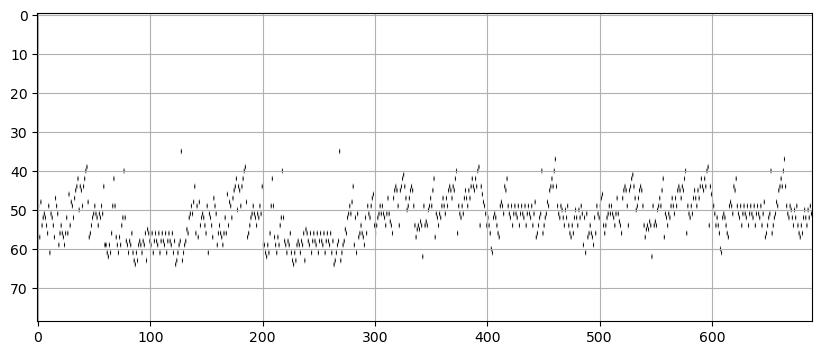

In [7]:
plt.figure(figsize=(10, 4))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

We want to train a language model, i.e. a model thats predict a note given past notes: $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.

A simple way to do this is to create (for each MIDI sequence and for each possible starting note `t` within this MIDI sequence) two sequences:
- an input sequence $x$:
  - which contains a sub-sequence of length `model_T_x`;  this sub-sequence range from `t` to `t+model_T_x-1`
- an output sequence $y$ :
  - which contains the same sub-sequence but delayed by one time step: ranging from `t+1` to `t+model_T_x`

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_03.png">



In [8]:
def F_convert_list_2_data(X_list, model_T_x, sequence_step=1):
    """
    convert X_list to input X_train and output Y_train training data

    Parameters
    ----------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time

    Returns
    -------
    X_train:
        the set of all m input sequences; np.array of shape (m, model_T_x, n_x)
    Y_train:
        the set of all m output sequences; np.array of shape (m, model_T_x, n_x)

            note:   m is the total number of training items,
                    it is be larger than the number of MIDI files since we use several starting time t in each MIDI file
    """

    if student:
        # --- START CODE HERE (02)
        X_train_list = []
        Y_train_list = []
        
        for X_ohe in X_list:
            midi_T_x, n_x = X_ohe.shape
            for t in range(0, midi_T_x-model_T_x, sequence_step):
                x = X_ohe[t:t+model_T_x,:]
                y = X_ohe[t+1:t+model_T_x+1,:]
                X_train_list.append(x)
                Y_train_list.append(y)
        # --- END CODE HERE

    X_train = np.asarray(X_train_list)
    Y_train = np.asarray(Y_train_list)

    return X_train, Y_train

X_train.shape: (20901, 100, 79)
Y_train.shape: (20901, 100, 79)


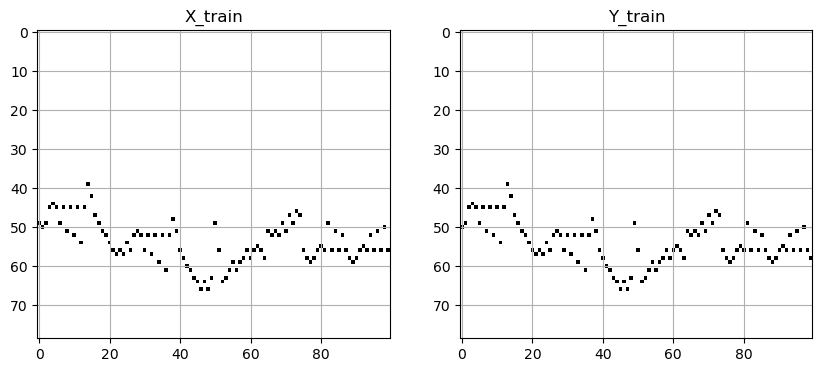

In [9]:
X_train, Y_train = F_convert_list_2_data(X_list, model_T_x)
# --- X_train is of shape (m, model_T_x, n_x)
print("X_train.shape:", X_train.shape)
# --- Y_train is of shape (m, model_T_x, n_x)
print("Y_train.shape:", Y_train.shape)


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(X_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('X_train')
plt.subplot(1,2,2); plt.imshow(Y_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('Y_train')
plt.set_cmap('gray_r')

# Training the language model

To learn the language model we will train an RNN with input `X_train` and output `Y_train`.  
For each example, we give to the network a sequence of notes from `t` to `t+model_T_x-1`  and ask the network to predict the following note of each sequence `t+1` to `t+model_T_x`.
We already created those in `X_train` and `Y_train`.




## Model 1: using LSTM
The network architecture is the following:
- (1a) a layer of `LSTM` with `model_n_a` units
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with `model_n_a` units
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with `model_n_a` units
- (4a) a layer of `Dense` with `model_n_a` units with a `tanh` activation
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output



In [10]:
# --- Create the model
K.clear_session()

if student:
    class BachNet(tf.keras.Model):
        def __init__(self, n_x, model_T_x, model_n_a):
            super(BachNet, self).__init__()
            self.LSTM1 = layers.LSTM(model_n_a, return_sequences=True)
            self.LSTM2 = layers.LSTM(model_n_a, return_sequences=True)
            self.LSTM3 = layers.LSTM(model_n_a, return_sequences=True) 
            self.Dropout1 = layers.Dropout(0.3)
            self.Dropout2 = layers.Dropout(0.3)
            self.Dropout3 = layers.Dropout(0.3)
            self.Dense1 = layers.Dense(model_n_a, activation='tanh')
            self.Dense2 = layers.Dense(n_x, activation='softmax')
            
        def call(self, X):
            X = self.LSTM1(X)
            X = self.Dropout1(X)
            X = self.LSTM2(X)
            X = self.Dropout2(X)
            X = self.LSTM3(X)
            X = self.Dense1(X)
            X = self.Dropout3(X)
            X = self.Dense2(X)
            return X

model = BachNet(n_x, model_T_x, model_n_a)
print(X_train.shape)
print(model(X_train[:64,:,:]).shape)
print(model.summary())

(20901, 100, 79)
(64, 100, 79)


Model: "bach_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (64, 100, 32)          │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (64, 100, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (64, 100, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 100, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 100, 79)          │         2,607 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,639 (135.31 KB)

 Trainable params: 34,639 (135.31 KB)

 Non-trainable params: 0 (0.00 B)

None


## Model 2: using Transformer

You will use a Transformer architecture. More precisely the decoder part of a Transformer (which is an Auto-Regressive model, as GPT-2).

You will use the ready-made block `TransformerDecoder` from the `keras_nlp` package.
This block contains a single block of a decoder with its self-attention layer (multi-head), its causal masking (necessary for auto-regressive models), its layer-normalization, its residual connections, and its feed-forward part.
You will use `num_layers`=4 of such block.

For each block, you only need to specify
- `num_heads`=2: the number of heads of its muti-head attention
- `intermediate_dim`=128: the internal dimension of its feed-forward part
- `dropout`=0.1: the dropout value, shared by MultiHeadAttention and feedforward network.

The decoder ends with a `Dense` layer of `n_x` dimension with a `softmax` output.

During the forward, you need to add a **positional encoding** to the input `X`.
This is the goal of the function `F_positional_encoding`.
We use the positonal encoding proposed in [Vaswani et al. "Attention Is All You Need", NIPS, 2017].
$$
angle(pos,d) = \frac{pos}{10000^{2d/D}}\\
PE(pos,2d)=\sin \left( angle(pos,d) \right)\\
PE(pos,2d+1)=\cos \left( angle(pos, d) \right)
$$
In this
- `pos` is the temporal position (which ranges from 0 to `model_T_x` in our case);
-`d`is the dimension (which ranges from 0 to `n_x` in our case)

In [11]:
def F_positional_encoding(model_T_x, n_x):
    """
    arguments
        model_T_x: length of the sequence
        n_x: number of dimensions
    return
        PE_m: positional embedding matrix of dimensions (1, pos_v, dim_v)
    """
    # --- START CODE HERE (04)
    if student:
       
        angle_rate_m = 10000
        pos_v = np.arange(0, model_T_x)[:, np.newaxis]
        d_v = np.arange(0, n_x)[np.newaxis, :]
        P = F_get_angles(pos_v, d_v, n_x, angle_rate_m)
        P[:,0::2] = np.sin(P[:,0::2])
        P[:,1::2] = np.cos(P[:,1::2] )
        PE_m = P[np.newaxis, :,]
        return PE_m
    # --- END CODE HERE
def F_get_angles(pos_v, d_v, D, angle_rate_m = 10000):
    """
    arguments
        pos_v: np.array with all positions
        d_v: np.array with all dimensions
        D: total number of dimensions
    return
        angle_m of dimensions (len(pos_v), len(d_v))
    """
    # --- START CODE HERE (04)
    if student:
        #angle_m = np.zeros((len(pos_v), len(d_v.shape))) 
        angle_m = pos_v / angle_rate_m ** (2 * d_v / D)
    return angle_m
    # --- END CODE HERE

In [12]:
if student:
    # --- START CODE HERE (04)
    class BachNet(tf.keras.Model):
        def __init__(self, n_x, model_T_x, num_layers, num_heads, intermediate_dim, dropout):
            super(BachNet, self).__init__()
            self.transformer_decoder_block = []
            for _ in range(num_layers):
                block = TransformerDecoder(intermediate_dim, num_heads, dropout=dropout)
                self.transformer_decoder_block.append(block)
            self.Dense = layers.Dense(n_x, activation='softmax')
            self.PE_m = F_positional_encoding(model_T_x, n_x)

        def call(self, X):
            X = X + self.PE_m
            for block in self.transformer_decoder_block:
                X = block(X)
            X = self.Dense(X)
            return X
    # --- END CODE HERE


model = BachNet(n_x=n_x, model_T_x=model_T_x, num_layers=4, num_heads=2, intermediate_dim=128, dropout=0.1)
print(X_train.shape)
print(model(X_train[:64,:,:]).shape)
print(model.summary())

(20901, 100, 79)
(64, 100, 79)


Model: "bach_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_decoder             │ (64, 100, 79)          │        45,708 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_1           │ (64, 100, 79)          │        45,708 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_2           │ (64, 100, 79)          │        45,708 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_3           │ (64, 100, 79)          │        45,708 │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 100, 79)          │         6,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,152 (738.88 KB)

 Trainable params: 189,152 (738.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
# --- Compile and fit the model
callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.1, shuffle=True, callbacks=[callback])

Epoch 1/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.2673 - loss: 2.4978 - val_accuracy: 0.3157 - val_loss: 2.7358
Epoch 2/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.7215 - loss: 0.8748 - val_accuracy: 0.3285 - val_loss: 4.3354
Epoch 3/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.8847 - loss: 0.3692 - val_accuracy: 0.3415 - val_loss: 5.2646
Epoch 4/100
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.9105 - loss: 0.2845 - val_accuracy: 0.3467 - val_loss: 5.8559


# Generating a new sequence by sampling the language model


- we first randomly choose a starting note among the `n_x` possible ones. For this you can use `
np.random.multinomial` and either
    - assume an uniform distribution
    - compute a prior note distribution (you can do this by computing the number of occurences of each notes in the training set)
- we then create an artificial input `x` that can be used by our model. Our model requires data `x` of shape `(m, T_x, n_x)`. In our case
    - `m=1` since we have only one sequence,
    - `T_x` should be the length used when training our model so it is `model_T_x` and
    - `n_x` is the number of notes.
- we set the data at time `t=0`, `x[0,0,:]`, to our random note (after converting it to a one-hot-encoding)
- we then feed our model with this data. The model has been trained to predict $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.
The output of the model `y` is of shape `(m, T_x, n_x)`. But only the first value is meaningfull so far.
The output value `y` at `t=0` is $p(x^{<1>} | x^{<0>})$, i.e. the probability of each note to be the second note given our first note as input. Actually `y` at `t=0` (noted `y[0,0,:]`) is a vector that represents the probability of each of the `n_x` notes given the one at `t=0`. We can then either
    - (a) get the most likely class from the vector `y[0,0,:]` (`np.argmax`) or
    - (b) consider the vector `y[0,0,:]` as a multinomial distribution and sample from it (`np.random.multinomial`). If the vector is too peaky (one of the probability is much larger than the other) we can flatten it using a temperature scaling (see below).
- whathever (a) or (b), the selected note is now considered as the note at `t=1`. We therefore add it (after conversion to one-hot-encoding) to the input data $x$ at time `t=1`: `x[0,1,:]`.
- we then feed our model with this new `x`. The output of the model at `t=1`, `y[0,1,:]`, is $p(x^{<2>} | x^{<0>}, x^{<1>})$. We then either perform (a) or (b), plugs the new selected notes as the input $x$ at `t=2`, `x[0,2,:]`, and repeat the process for the following times until we reach `model_T_x`.

To apply a temperature $T$ parameter to a discrete probability $\{p_c\}_{c \in \{1,...,K\}}$, you can use
$$p'_c = \frac{e^{\log(p_c)/T}}{\sum_{k=1}^K e^{\log(p_k)/T}}$$ where $K$ is the number of classes.

In [14]:
def F_get_max_temperature(proba_v, temperature=1):
    """
    apply a temperature to the input probability
    consider it as a multinomial distribution
    sample it

    Parameters
    ----------
    proba_v: np.array(n_x)
        input probability vector
    temperature: scalar float
        temperature parameters to apply to proba_v,
        >1 leads to more flatten probability,
        <1 leads to more peaky probability

    Returns
    -------
    index_pred: scalar int
        position of the sampled data in the probability vector
    pred_v: np.array(n_x)
        modified probability
    """
    if student:
        # --- START CODE HERE (05)
        pred_v = np.zeros(len(proba_v))
        s = 0
        for i in range(len(proba_v)):
            s += np.exp(np.log(proba_v[i])/temperature)
            
        for i,note in enumerate(proba_v):
            pred_v[i] = (np.exp(np.log(note)/temperature))/s
            
        index_pred = np.random.multinomial(1, pred_v).argmax()
        # --- END CODE HERE

    return index_pred, pred_v

In [15]:
def F_sample_new_sequence(model, prior_v):
    """
    sample the trained language model to generate new data

    Parameters
    ----------
    model:
        trained language model

    Returns
    -------
    note_l: list of int
        list of generated notes (list of their index)
    prediction_l: list of np.array(n_x)
        list of prediction probabilies over time t (each entry of the list is one of the y[0,t,:])
    """

    if student:
        # --- START CODE HERE (06)
        note_l = []
        prediction_l = []
        note_l.append(np.where(prior_v == 1))
        
        input = np.zeros((1, model_T_x, n_x))
        
        for i in range(model_T_x):
            input[0, i ,note_l[i]] = 1
            
            next = model.predict(input)
            prediction_l.append(next[0,i,:])
            
            index_pred, _ = F_get_max_temperature(prediction_l[i])
            note_l.append(index_pred)
            
        # --- END CODE HERE

    return note_l, prediction_l

### Display the generated sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

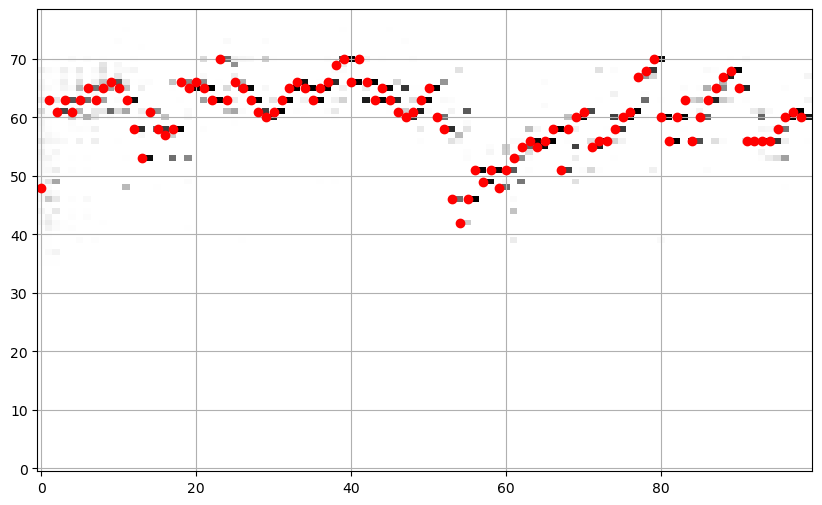

In [16]:
if False:
    prior_v = np.ones(n_x)/n_x
else:
    sum_v = np.zeros(n_x)
    for X_ohe in X_list: sum_v += np.sum(X_list[0], axis=0)
    prior_v = sum_v/np.sum(sum_v)

note_l, prediction_l = F_sample_new_sequence(model, prior_v)


note_l = note_l[2::]
print(note_l)

plt.figure(figsize=(10, 6))
plt.imshow(np.asarray(prediction_l).T, aspect='auto', origin='lower', interpolation='none')
plt.plot(note_l, 'ro')
plt.set_cmap('gray_r')
plt.grid(True)


### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (`note_l`) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [17]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [18]:
%matplotlib inline
audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)